# Ford Go Bike Analysis

In [1]:
import requests
import os
import os.path
from bs4 import BeautifulSoup
import shutil
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from geopy import Point, distance
from matplotlib import rcParams
from pandas.api.types import CategoricalDtype
%matplotlib inline

In [2]:

df = pd.read_csv("./data/cleaned_df.csv")
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,computed_duration_sec
0,4902,No,52185,13,37.794231,-122.402923,Commercial St at Montgomery St,2019-03-01 08:01:55.975,1984,Male,21,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),2019-02-28 17:32:10.145,Customer,52185.0
1,5905,No,61854,3,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),2019-03-01 05:24:08.146,1972,Male,86,37.769305,-122.426826,Market St at Dolores St,2019-02-28 12:13:13.218,Customer,61854.0
2,6638,No,36490,70,37.773311,-122.444293,Central Ave at Fell St,2019-03-01 04:02:36.842,1989,Other,375,37.774836,-122.446546,Grove St at Masonic Ave,2019-02-28 17:54:26.010,Subscriber,36490.0
3,4898,Yes,1585,222,37.792714,-122.248780,10th Ave at E 15th St,2019-03-01 00:20:44.074,1974,Male,7,37.804562,-122.271738,Frank H Ogawa Plaza,2019-02-28 23:54:18.549,Subscriber,1585.0
4,5200,No,1793,323,37.798014,-122.405950,Broadway at Kearny,2019-03-01 00:19:51.760,1959,Male,93,37.770407,-122.391198,4th St at Mission Bay Blvd S,2019-02-28 23:49:58.632,Subscriber,1793.0


### Who are bike renters?

* 74% of the total bike rentals are done by men
* 24% by females. Gender ratio between male and female is approximately 3:1. 
* There a small percentage that belongs to other category but we can ignore it for analysis purposes.

In [5]:
# Scale values in y axis (express in thousands)
def scale_yaxis(ax):
    fig.canvas.draw()
    ax.set_yticklabels([y.get_text()[:-3]  for y in ax.get_yticklabels()])

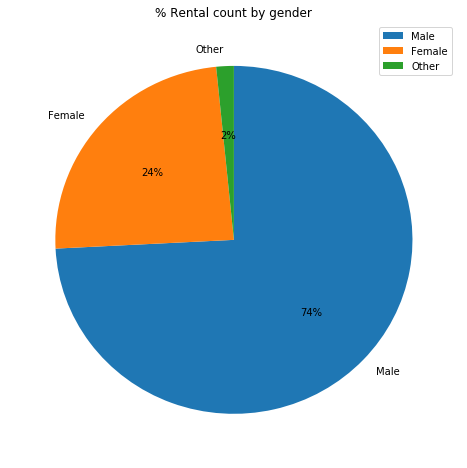

In [6]:
ax = \
df[['bike_id', 'member_gender']]\
.groupby('member_gender')\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})\
.sort_values(by=['rental_count'], ascending=[False])\
.reset_index(drop=True)\
.set_index('member_gender')\
.plot.pie(y=0, 
          autopct='%1.0f%%', 
          startangle=90,
          counterclock=False,
          figsize=(8, 8))

ax.set_title('% Rental count by gender');
ax.set_ylabel('');


### Which age category do they belong to?

* Median age of female biker = 32
* Median age of male biker = 33

In [7]:
gender_age_df = df.query("member_gender == 'Female' or member_gender == 'Male'")\
[['bike_id', 'member_gender', 'member_age', 'user_type', 'duration_sec', 'distance_in_mile']]
gender_age_df['duration_min'] = gender_age_df.duration_sec / 60
fig, ax = plt.subplots(figsize=(10,5))
color = sns.color_palette()

ax = sns.boxplot(x="member_gender", y="member_age", data=gender_age_df, color=color[0])
ax.set_ylabel('Age (In years)')
ax.set_title('Distribution of member age by gender');


KeyError: "['member_age' 'distance_in_mile'] not in index"

### Does subscribers & non-subscribers show different age profile?

* Non-subscribers are relatively younger people. Subscribers have higher median age as well and higher 25 & 75 percentile values compared to non-subscribers (customers). This observation holds good for both genders.

* Median age of female and male subscribers are 32 & 33 years respectievly compared to 30 & 31 for same gender category in customers.

In [ ]:
g = sns.catplot(
    x="member_gender", 
    y="member_age", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[0]
)
plt.gcf().set_size_inches(16, 8)
plt.suptitle('Distribution of age by user type and gender', size=16)
plt.subplots_adjust(top=0.85)
g.axes[0][0].set_ylabel('Age', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][0].set_title('User Type = Customer', size=16)
g.axes[0][1].set_title('User Type = Subscriber', size=16);


### Who rides more - subscribers or customers?

* On an average, customers travel more miles than subscribers
* Medain value of bike ride duration for customers is higher than that of subscribers

In [ ]:
g = sns.catplot(
    x="member_gender", 
    y="distance_in_mile", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[0]
)
plt.gcf().set_size_inches(16, 8)
plt.suptitle('Distribution of distance (mile) by user type and gender', size=16)
plt.subplots_adjust(top=0.85)
g.axes[0][0].set_ylabel('Distance (mile)', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][0].set_ylim(bottom=0,top=3)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][1].set_ylim(bottom=0,top=3)
g.axes[0][0].set_title('User Type = Customer', size=16)
g.axes[0][1].set_title('User Type = Subscriber', size=16);

In [ ]:
g = sns.catplot(
    x="member_gender", 
    y="duration_min", 
    col="user_type", 
    data=gender_age_df, 
    kind="box", 
    color = sns.color_palette()[1]
)
plt.gcf().set_size_inches(16, 8)
plt.suptitle('Distribution of duration (min) by user type and gender', size=16)
plt.subplots_adjust(top=0.85)
g.axes[0][0].set_ylabel('Duration (min)', size=16)
g.axes[0][0].set_xlabel('Gender', size=16)
g.axes[0][0].set_ylim(bottom=0,top=50)
g.axes[0][1].set_xlabel('Gender', size=16)
g.axes[0][1].set_ylim(bottom=0,top=50)
g.axes[0][0].set_title('User Type = Customer', size=16)
g.axes[0][1].set_title('User Type = Subscriber', size=16);

In [ ]:
gender_user_agg_df = \
gender_age_df.query("member_gender == 'Male' or member_gender == 'Female'")[['duration_min', 'distance_in_mile', 'bike_id', 'user_type', 'member_gender']]\
.groupby(['user_type', 'member_gender'])\
.agg({'bike_id': 'count', 'duration_min': {'median'}, 'distance_in_mile': {'median'}})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

gender_user_agg_df.columns = gender_user_agg_df.columns.droplevel(1)
gender_user_agg_df.columns = ['user_type', 'member_gender', 'rental_count', 'median_duration_min', 'median_distance_mile']

gender_user_agg_df


In [ ]:


# Visualization of monthly metrics
fig, ax = plt.subplots(1, 3, figsize=(20,8),sharex=True)
fig.suptitle('Ride duration, distance traveled and rental count by user type & gender', fontsize=20)

metrics = ['median_duration_min','median_distance_mile', 'rental_count']
for i,j in enumerate(range(len(ax))):
    g = sns.catplot(x="member_gender", y=metrics[i], hue="user_type", data=gender_user_agg_df, kind="bar", ax=ax[j])    

y_labels = ['Median Ride duration (min)', 'Median Distance traveled (mile)', 'Rental count']
for i in range(len(ax)):
    ax[i].set_ylabel('%s' % y_labels[i], fontsize=12)
    ax[i].set_xlabel('Gender', fontsize=12)
    if (i == len(ax) - 1):
        ax[i].tick_params(labelrotation=45)

# Hack to eliminate empty grids at the end
for i in range(2,5):
    plt.close(i)



On the average, customers tend to travel more miles per ride compared to subscribers. Their average duration is also higher compared to subscribers.

Number of rental count for subscribers is several times higher than occasional customers. This seems logical as subscribers pay monthly fee to get that service and they may wish maximize the benefit of paid subscription.

In [ ]:
# Compute monthly metrics - cumulative rental count, cumulative distance & cumulative usage in hours
monthly_metric_df = \
df.query('end_time_year_month < "2019-03"')[['end_time_year_month', 'bike_id', 'duration_sec', 'distance_in_mile']]\
.groupby(['end_time_year_month'])\
.agg({'bike_id': ['count', lambda x: x.nunique()], 'duration_sec': 'sum', 'distance_in_mile': 'sum'})\
.reset_index()

monthly_metric_df.columns = monthly_metric_df.columns.droplevel(1)

monthly_metric_df.columns = ['end_time_year_month', 'rental_count', 'bike_count', 'duration_sec', 'distance_in_mile']

monthly_metric_df['cumulative_rental_count'] = monthly_metric_df.rental_count.transform(np.cumsum)
monthly_metric_df['cumulative_distance_in_mile'] = monthly_metric_df.distance_in_mile.transform(np.cumsum)
monthly_metric_df['cumulative_duration_hours'] = (monthly_metric_df.duration_sec.transform(np.cumsum) / (60 * 60))


### How is the business doing in past few years?

* All three cumulative values show steady upward trend with almost equal slope indicating growth of business. 
* There is growth spurt from April 2018 till October 2018 showing relatively higher growth rate compared to same period in previous year. After October 2018, rental business shows signs of slow down. 


In [ ]:
# Visualization of monthly metrics
fig, ax = plt.subplots(1, 3, figsize=(20,6),sharex=True)
fig.suptitle('Cumulative Ride duration, distance traveled and rental count by month', fontsize=20)

metrics = ['cumulative_duration_hours','cumulative_distance_in_mile', 'cumulative_rental_count']
for i,j in enumerate(range(len(ax))):
    sns.set(style="whitegrid")
    g = sns.lineplot(x="end_time_year_month", y=metrics[i], data=monthly_metric_df, ax=ax[j])    

y_labels = ['Cum. ride duration (hours)', 'Cum. distance traveled (mile)', 'Cum. rental count']

xtick_labels = [x if index % 2 == 0 else '' for index, x in enumerate(monthly_metric_df.end_time_year_month.unique().tolist())]
for i in range(len(ax)):
    ax[i].tick_params(labelrotation=45)
    ax[i].set_xticklabels(xtick_labels)
    ax[i].set_ylabel('%s' % y_labels[i], fontsize=14)
    ax[i].set_xlabel('Months (Year-month)', fontsize=14)


# Hack to eliminate empty grids at the end
for i in range(2,5):
    plt.close(i)

### Does rental volume show seasonality?

* Bike rental volume goes down during winter season which is also the season when it rains.
* Dip in monthly volume can be observer in Nov_dec 2017 and again getting repeated in 2018

In [ ]:
# Line graph visualization for monthly bike rental count and biked duration plotted in dual-axis graph
fig, ax = plt.subplots(figsize=(16,8))

line1 = ax.plot(monthly_metric_df.end_time_year_month, monthly_metric_df.rental_count, alpha=0.6, c='b')

ax.set_xticklabels([x for x in monthly_metric_df.end_time_year_month], rotation=40)
ax.set_title('Bike rental count & rental duration by month', fontsize=14)
ax.set_xlabel('Rental Date (Year-Month)', fontsize=14)
ax.set_ylabel('Rental count',fontsize=14) 

ax2 = ax.twinx()
line2 = ax2.plot(monthly_metric_df.end_time_year_month, monthly_metric_df.duration_sec / (60 * 60), c='r', alpha=0.6)
ax2.set_ylabel('Rental duration (hour)',fontsize=14);
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, ['rental count', 'duration (hours)'], loc=2);

In [ ]:
gender_agg_df = df[['end_time_year_month', 'member_gender', 'bike_id']]\
.groupby(['member_gender', 'end_time_year_month'], as_index=False)\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})\
.pivot(index='end_time_year_month', columns='member_gender', values='rental_count')\
.reset_index()

In [ ]:
# Compute rental number and get last year's metric value for same month in one record
from dateutil.relativedelta import relativedelta
seasonal_df = \
df.query('end_time_year_month < "2019-03"')[['end_time_year_month', 'bike_id']]\
.groupby(['end_time_year_month'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})
seasonal_df['prev_year_month'] = seasonal_df.end_time_year_month\
.apply(lambda x: (datetime.strptime(x, '%Y-%m') + relativedelta(years=-1)).strftime('%Y-%m'))

seasonal_df = pd.merge(seasonal_df[['end_time_year_month', 'rental_count']], seasonal_df, left_on='end_time_year_month', right_on='prev_year_month')\
.sort_index()[['end_time_year_month_y', 'rental_count_x', 'rental_count_y']]\


seasonal_df.columns = ['year_month', 'ly_same_month_rental_count', 'rental_count']
seasonal_df['pct_increase'] = seasonal_df\
.apply(lambda row: int((row['rental_count'] - row['ly_same_month_rental_count']) * 100 / row['ly_same_month_rental_count']), axis=1)



* Number of rentals per month is compared with same month in previous year. For example October 2018 is compared in October 2017. Percent increase of the metric value from same month in previous year is used as basis and posted as annotation. 

* Though business slows down during winter months, rental volume increased by 50-60% during the period. For summer months, business grew by more than 100%.

In [ ]:
# Visualization of monthly rental volume compared to data from same month last year
fig, ax = plt.subplots(figsize=(16,8))
width = 0.35
ind = np.arange(len(seasonal_df.year_month.tolist()))
plt.bar(
    ind,
    seasonal_df.ly_same_month_rental_count,
    alpha=0.8, 
    color='r',
    width=width
);
ax2 = plt.bar(
    ind + width,
    seasonal_df.rental_count,
    alpha=0.8, 
    color='b',
    width=width
);

labels = map(lambda x: str(x) + '%', seasonal_df.pct_increase.tolist())

plt.legend(['Month (Prev Year)', 'Current Month'])
plt.xticks(ind + width / 2.0, seasonal_df.year_month.tolist(), rotation=45);

plt.ylabel('Rental Count')
plt.xlabel('Month (Year-month)')
plt.title('Monthly number of rentals compared with same month of previous year');

for rect, label in zip(ax2.patches, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [ ]:
# Aggregate cumulative rental volume by gender and age range
agg_df = df.query('end_time_year_month <= "2019-03"')[['member_gender', 'member_age_bracket', 'bike_id', 'end_time_year_month']]\
.groupby(['member_gender', 'member_age_bracket', 'end_time_year_month'])\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})

agg_df['cumulative_rental_count'] = \
agg_df.groupby(['member_gender', 'member_age_bracket']).rental_count.transform(np.cumsum)
agg_df.reset_index(inplace=True)
agg_df = agg_df.query("end_time_year_month >= '2017-07' and end_time_year_month < '2019-03'")


* 25 - 30 & 30- 35 are fastest growing age brackets in both gender who are increasingly using bike rental
* For male members, 30-35 age bracket has significantly outperformed 25-30 age bracket
* For female members, 25-30 and 30-35 age groups are competing very closely.
* 25-30 female age group surpasses 30-35 in bike usage around October 2018 and maintained the lead till March 2019.

In [ ]:
# Plot cumulative rental count for female bikers upto age bracket 45 - 50 years
fig, ax = plt.subplots(figsize=(16,8))
sns.set(style="whitegrid")
sns.lineplot(data=agg_df.query("member_gender == 'Female' and member_age_bracket >= '20 - 25' and member_age_bracket <= '45 - 50'"), 
             x='end_time_year_month', 
             y='cumulative_rental_count', 
             hue='member_age_bracket', 
             estimator=None);
ax.set_ylabel('Cumulative rental count', fontsize=14)
ax.set_xlabel('Months (Year-Month)', fontsize=14)
plt.xticks(rotation=25)
ax.set_title('Cumulative monthly rental count of different age groups of female bikers', fontsize=14);
plt.legend().get_texts()[0].set_text("Age bracket")



In [ ]:
# Plot cumulative rental count for male bikers
fig, ax = plt.subplots(figsize=(16,8))
sns.set(style="whitegrid")
sns.lineplot(data=agg_df.query("member_gender == 'Male' and member_age_bracket >= '20 - 25' and member_age_bracket <= '45 - 50'"), 
             x='end_time_year_month', 
             y='cumulative_rental_count', 
             hue='member_age_bracket', 
             estimator=None);
ax.set_ylabel('Cumulative rental count', fontsize=14)
ax.set_title('Cumulative monthly rental count of different age groups of male bikers', fontsize=14)
plt.xticks(rotation=25)
ax.legend()
ax.set_xlabel('Date (Year-Month)', fontsize=14)
plt.legend().get_texts()[0].set_text("Age bracket")

    

In [ ]:
# Aggregate bike rental number by day of week
day_agg_df = \
df.groupby(['day_of_week']).agg({'bike_id': 'count'}).reset_index().rename(columns={'bike_id': 'rental_count'})
day_agg_df['total_rental_count'] = day_agg_df.rental_count.sum()
day_agg_df['pct_of_total'] = round(day_agg_df.rental_count * 100 / day_agg_df.total_rental_count, 2)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['day_of_week'])

* Bike rental business shows periodicity with respect to day of week. 
* Number of rentals are lowest over the weekend - Saturday & Sunday. Monday & Friday are relatively low volume days compared to middle of the week. 
* This brings an interest guess about the purpose of bike rental - whether the main usage is  - pleasure or business use? The fact that the volume of business goes down drastically over the weekend and peaks up steam during middle of the week is indicative that the prime usage is for commuting to office. 

In [ ]:
plt.subplots(figsize=(20,10))
sns.set(style="whitegrid")
g = sns.barplot(x="day_of_week", 
                 y="pct_of_total", 
                 data=day_agg_df, 
                 color=sns.color_palette()[0], 
                 alpha = 0.6)
g.set_xlabel('Day of week', fontsize=16)
g.set_ylabel('% of total rentals', fontsize=16)
g.set_title('% of total rentals by day of week', fontsize=16);

In [ ]:
# Aggregate bike rental number by day of week

def agg_rental_count_by_user_type(row):
    return day_agg_df.query("user_type == '%s'" % row['user_type'])[['rental_count']].sum()

day_agg_df = \
df.groupby(['day_of_week', 'user_type']).agg({'bike_id': 'count'}).reset_index().rename(columns={'bike_id': 'rental_count'})
day_agg_df['total_rental_count'] = day_agg_df.apply(lambda row: agg_rental_count_by_user_type(row), axis=1)
day_agg_df['pct_of_total'] = round(day_agg_df.rental_count * 100 / day_agg_df.total_rental_count, 2)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['day_of_week'])

* Rental behavior of `customers` is different from that of `subscribers`. 
* Rental volume of customers increases during the weekend. One hypothesis is - this group rent the bike primarily for leisure usage.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(style="whitegrid")
g = sns.catplot(
    x="day_of_week", 
    y="pct_of_total", 
    hue="user_type", 
    data=day_agg_df, 
    kind="bar",
    ax=ax)
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('% of daily total rides for respective user type', fontsize=14)
ax.set_title('% of daily rentals by day of week and user type', fontsize=14);
plt.close(2)



In [ ]:
def agg_by_user_type_month(x, y):
    return day_agg_df.query("user_type == '%s' and end_time_year_month == '%s'" % (x,y))['rental_count'].sum()

# Aggregate bike rental number by day of week, user_type and month
day_agg_df = \
df.query("end_time_year_month >= '2018-01' and end_time_year_month <= '2018-12'").\
groupby(['day_of_week', 'user_type', 'end_time_year_month']).agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

day_agg_df['monthly_rental_count_utype'] = \
day_agg_df.apply(lambda row: agg_by_user_type_month(row['user_type'], row['end_time_year_month']), axis=1)

day_agg_df['pct_of_total'] = day_agg_df.rental_count * 100 / day_agg_df.monthly_rental_count_utype
day_agg_df.pct_of_total = day_agg_df.pct_of_total.astype(int)

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
day_agg_df['day_of_week'] = day_agg_df['day_of_week'].astype(cat_type)
# Sort dataframe based on days of the week (categorical variable)
day_agg_df = day_agg_df.sort_values(by=['end_time_year_month','day_of_week'])


This multivariate plot below coroborates some of the pervious observation.

* Across all months weekend volumes are always lower than the weekday.
* For non-subscribers higher percentage of bike rental happens on weekends. This segment appears to be casual users.
* For subscribers, the rental volume peaking near the middle of the week, is only partly supported by this analysis. Months like January, Febuary or March follow that pattern. April shows Mondays as the highest volume days and then % volume going down progressively for rest of the week. 2018 April calendar shows there were 5 Sundays and 5 Mondays in that month and 4 for the remaining days of the week. That can partly explain that trend.

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(20, 16), sharex="col", sharey="row")
fig.suptitle('Total rental % by day of week, month & user type', fontsize=20)
plt.subplots_adjust(wspace=0, hspace=.01, top=0.96)
all_months = day_agg_df.end_time_year_month.unique().tolist()
index = 0
g = []
for j in range(len(ax)):
    for i in range(len(ax[j])):
        temp_df = day_agg_df.query("end_time_year_month == '%s'" % all_months[index])
        for item in ([ax[j][i].title, ax[j][i].xaxis.label, ax[j][i].yaxis.label] + ax[j][i].get_xticklabels() + ax[j][i].get_yticklabels()): 
            item.set_fontsize(12)
        g = \
            sns.catplot(
                x="day_of_week", 
                y="pct_of_total", 
                hue="user_type", 
                data=temp_df,  
                kind="bar", 
                ax=ax[j][i]
            )
        g.axes[0][0].set_xlabel('')
        index = index + 1
 
for i in range(2,14):
    plt.close(i)
    
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
index = 0
label_index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].set_title(month_labels[label_index],x=0.5, y=0.9)
        if j == 0 and i == 2:
            pass
        else:
            ax[j][i].get_legend().set_visible(False)
        if i == 0:
            ax[j][i].set_ylabel('Rental pct in same user type', fontsize=12)
            ax[j][i].set_yticks([0, 5, 10, 15, 20])
            index = index + 1
        else:
            ax[j][i].set_ylabel('')
        if j == len(ax) - 1:
            ax[j][i].set_xlabel('Day of the week', fontsize=12)
            ax[j][i].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
        else:
            ax[j][i].set_xlabel('')
        label_index = label_index + 1

In [ ]:
# Rental volume aggregation by hour and day type (week day / weekend)
def agg_rental_by_day_type(row):
    return hourly_df.query("is_weekend == %s" % (row['is_weekend']))['rental_count'].sum()

df['is_weekend'] = df.day_of_week.apply(lambda x: True if x in ['Saturday', 'Sunday'] else False)

hourly_df = df.query("end_time_year_month < '2018-03'")[['end_time_hour', 'is_weekend', 'bike_id']]\
.groupby(['end_time_hour', 'is_weekend'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

hourly_df['total_hourly_rental'] = hourly_df.apply(lambda row: agg_rental_by_day_type(row), axis=1)
hourly_df['pct_hourly_rental'] = round(hourly_df.rental_count * 100 / hourly_df.total_hourly_rental, 2)


* Week day rental pattern is very different from week day pattern.
* Week days shows a bimodal distribution with two clear peaks during office commuting hours 7:00 - 10:00 AM and then again in the evening when commuters head out from work between 3:00 PM - 7:30 PM
* Weekend shows business volume increasing smoothly from 9:00 AM till 12 noon and going down from noon time till 8 PM. Most probably these are for pleasure trips to city and surrounding areas.

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=hourly_df, 
             x='end_time_hour', 
             y='pct_hourly_rental', 
             hue='is_weekend', 
             estimator=None);
ax.set_ylabel('% hourly ride', fontsize=14)
ax.set_title('Percentage rental volume by hour of the day', fontsize=14);
ax.set_xlabel('Hour of the day (00 - 23)', fontsize=14)
plt.xticks(np.arange(0, 26, 2))
ax.legend(['Weekday', 'Weekend']);

In [ ]:
# Hourly bike rental volume segmented by gender and age bracket
hourly_df = df.query("end_time_year_month < '2018-03' and member_age_bracket >= '20 - 25' and member_age_bracket <= '30 - 35' and is_weekend == False")\
.query("member_gender == 'Male' or member_gender == 'Female'")[['end_time_hour', 'member_gender', 'member_age_bracket', 'bike_id']]\
.groupby(['end_time_hour', 'member_age_bracket', 'member_gender'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

def agg_rental_by_hour_age(row):
    return hourly_df.query("member_gender == '%s'" % \
                           (row['member_gender']))['rental_count'].sum()
    
hourly_df['total_rental_count'] = hourly_df.apply(lambda x: agg_rental_by_hour_age(x), axis=1)

hourly_df['pct_rental_count'] = hourly_df['rental_count'] * 100 / hourly_df['total_rental_count']

The faceted graph below displays % of total rental percentage segmented by hour of the day, age bracket & gender. Three groups chosen to be plotted are 20-25, 25-30 & 30-35. These are the three most active age groups within both genders.

Rental pattern by male bikers is same as their female counterparts. But relatively higher percentage of female bikers tend to reach their destination by 8:00 AM. 

In [ ]:
g = sns.FacetGrid(hourly_df, col="member_gender", hue='member_age_bracket')
g.map(sns.lineplot, 'end_time_hour','pct_rental_count', estimator=None, legend='full')
plt.gcf().set_size_inches(16, 8)
plt.legend(title='Age Group', fontsize=16)
g.axes[0][0].set_ylabel('% of total rental in same gender', size=16)
g.axes[0][0].set_xlabel('Hour of the day', size=16)
g.axes[0][1].set_xlabel('Hour of the day', size=16)
g.axes[0][0].set_title('Gender = Female', size=16)
g.axes[0][1].set_title('Gender = Male', size=16);
plt.suptitle("Rental % by gender, hour of the day and age brackets");

The faceted graph above displays total rental percentage segmented by hour of the day. Additional dimensions are gender and age bracket. Within each graph, I have chosen 3 age groups to be plotted 20-25, 25-30 & 30-35. These are the three most active age groups within both genders.

* Rental pattern by male bikers follows similar pattern as female counterparts.
* Relatively higher percentage of female bikers tend to reach their destination by 8:00 AM. This indicated by the sharp peak in the graph on left hand side.

To highlight this trend, I have combined male & female bikers in age group '30 - 35' into a single multi-line graph.

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=hourly_df.query("member_age_bracket == '30 - 35'"), 
             x='end_time_hour', 
             y='pct_rental_count', 
             hue='member_gender', 
             estimator=None);
ax.set_ylabel('Pct rental count for same gender', fontsize=14)
ax.set_title('Rental volume by hour of the day, gender and age brackets', fontsize=14)
plt.xticks(np.arange(0, 26, 2))
ax.set_xlabel('Hour of the day (00 - 23)', fontsize=14);

In [ ]:
median_rental_df = \
df.query("member_age_bracket >= '20 - 25' and member_age_bracket <= '35 - 40'")\
.query("member_gender == 'Male' or member_gender == 'Female'")\
.groupby(['member_gender', 'user_type', 'end_time_hour', 'day_of_week', 'end_date'])\
.agg({'bike_id': 'count'})\
.reset_index()\
.rename(columns={'bike_id': 'rental_count'})

median_rental_df = \
median_rental_df.groupby(['member_gender', 'user_type', 'end_time_hour', 'day_of_week'])\
.agg({'rental_count': 'median'})\
.reset_index()\
.rename(columns={'rental_count': 'median_rental_count'})

median_rental_df['median_rental_count'] = median_rental_df['median_rental_count'].astype('int')

day_hour_rental_df = \
median_rental_df.pivot_table(
    index=['end_time_hour','member_gender', 'user_type'], 
    columns='day_of_week', 
    values='median_rental_count', 
    fill_value = 0)\
.reset_index()[['end_time_hour', 'member_gender', 'user_type', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
 
day_hour_rental_df['user'] = day_hour_rental_df.apply(lambda row: row['member_gender'] + ' ' + row['user_type'], axis=1)




* Following group of four heat maps are corresponding 4 user segments - female customer, female subscriber, male customer & male subscriber. The annotations in the heat map show the median value of the bike rental count for age groups between 20 - 40 years. 

* Rental pattern shows non-subscribers are primarily using the rental during the weekend and subscribers are using it during regular commute hours between Monday through Friday.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15), sharex="col", sharey="row")
fig.suptitle('Variation of median rental volume by day of week, hour, gender & user type for 20-40 yrs', fontsize=20)
user = day_hour_rental_df.user.unique().tolist()
plt.subplots_adjust(wspace=0, hspace=.1, top=0.90)
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        temp_df = day_hour_rental_df.query("user == '%s'" % user[index])[['end_time_hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
        temp_df = temp_df.set_index('end_time_hour')
        index = index + 1
        g = sns.heatmap(temp_df, annot=True, fmt="d", linewidths=.2, cmap="YlGnBu", annot_kws={"size":16}, ax=ax[j][i]);
        
index = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        if i == 0:
            ax[j][i].set_ylabel('Hour of day', fontsize=14)
        else:
            ax[j][i].set_ylabel('')
        ax[j][i].set_title('%s' % user[index], fontsize=14)
        index = index + 1
        if j == len(ax) - 1:
            ax[j][i].set_xlabel('Day of the week', fontsize=14)
            ax[j][i].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
        else:
            ax[j][i].set_xlabel('')



## San Francisco Weather

In [ ]:
sf_weather_df = pd.read_csv("data/SF_Weather.csv")
sf_weather_df = sf_weather_df[sf_weather_df.NAME.str.startswith('SAN FRANCISCO DOWNTOWN')][['NAME', 'DATE', 'PRCP', 'TMIN', 'TMAX']]


In [ ]:
daily_agg_df = df[['end_date', 'day_of_week', 'bike_id']]\
.groupby(['end_date', 'day_of_week'], as_index=False)\
.agg({'bike_id': 'count'})\
.rename(columns={'bike_id': 'rental_count'})

merged_df = pd.merge(daily_agg_df, sf_weather_df, left_on='end_date', right_on='DATE')[['end_date', 'day_of_week', 'PRCP', 'TMIN', 'TMAX', 'rental_count']]\
.rename(columns={'PRCP': 'precipitation', 'TMIN': 'min_temp', 'TMAX': 'max_temp'})



In [ ]:
"""
Generic routine to plot dual y-axis line graph
Input parameters:
  df: dataframe containing bike rental count & precipitation data
  start_date: Period starting date in the format YYYY-MM-DD
  end_date: Period end date in . the format YYYY-MM-DD
"""
def plot_monthly_rental(df, start_date, end_date):
    daily_df = df.query("end_date >= '%s' and end_date <= '%s'" % (start_date, end_date))
    fig, ax = plt.subplots(figsize=(16,8))
    line1 = ax.plot(daily_df.end_date, daily_df.rental_count, c='b', alpha=0.8)
    ax.set_title('Daily bike rental count and rainfall (in inches) in San Francisco city for period: %s to %s' % (start_date, end_date), fontsize=14)
    ax.set_xlabel('Rental Date', fontsize=14)
    ax.set_ylabel('Rental count',fontsize=14) 

    ax2 = ax.twinx()
    line2 = ax2.plot(daily_df.end_date, daily_df.precipitation, c='g', alpha=0.8)
    ax2.set_ylabel('Precipitation (inches)',fontsize=14);
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1 + h2, ['rental count', 'precipitation'], loc=1);

    x_ticks = daily_df.query("day_of_week == 'Sunday'").end_date
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=45);
    ax.grid(b=True, alpha=0.4)
    
    
    


<ol>
<li>Daily precipitation data from NOAA has been plotted along with daily bike rental volume in the dual axis graph</li>
<li>With barely no rain happening between the months of May through October, rental volume follows the weekly cyclical pattern. Only a day of rain in the first week October didn't have any impact as amount of precipitation is only 0.2 inch</li>
</ol>

In [ ]:
# Daily bike rental count & preciptation number for Jan 2018 to Mar 2018
plot_monthly_rental(merged_df, '2018-01-01', '2018-03-31')

    

Rain in November and December impacts the business. Every of precipitation can be tied to a dip in bike rental

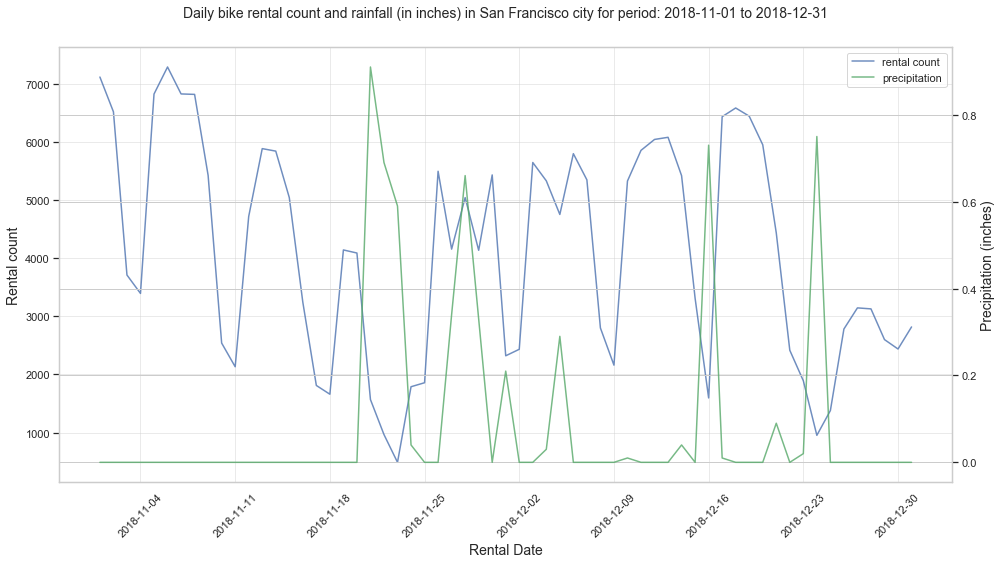

In [1083]:
# Daily bike rental count & preciptation number for Nov 2018 to Dec 2018
plot_monthly_rental(merged_df, '2018-11-01', '2018-12-31')